In [19]:
from pyspark.sql import SparkSession
import os
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("SQL").getOrCreate()

In [2]:
path = "/home/msi/beginning-apache-spark-3/chapter6/data/mobile"

there are 3 separate csv files on the folder `mobile`

In [12]:
mobileDataDF = spark.read.json(path)

> just for you see the content of folder `mobile`
> this 3 different files are gonna be copied into a folder called `input` with the idea of simulate
a stream of data

In [13]:
print(mobileDataDF.printSchema())

mobileDataDF.show()

root
 |-- action: string (nullable = true)
 |-- id: string (nullable = true)
 |-- ts: string (nullable = true)

None
+------+------+-------------------+
|action|    id|                 ts|
+------+------+-------------------+
|  open|phone1|2018-03-02T10:02:33|
|  open|phone2|2018-03-02T10:03:35|
|  open|phone3|2018-03-02T10:03:50|
| close|phone1|2018-03-02T10:04:35|
| crash|phone2|2018-03-02T11:09:13|
| swipe|phone5|2018-03-02T11:17:29|
| close|phone3|2018-03-02T10:07:35|
|  open|phone4|2018-03-02T10:07:50|
| close|phone2|2018-03-02T10:04:50|
|  open|phone5|2018-03-02T10:10:50|
+------+------+-------------------+



# Streaming

In [17]:
# schema for the data
mobileDataSchema = "`id` String, `action` String, `ts` Timestamp"


> Unlike the DataFrame covered in Chapter 4, this DataFrame is
a **streaming DataFrame**, and you MUST define beforehand the schema

In [34]:
# there is no input folder, (I create a empty one)
# (schema must be provided - you cannot infer a schema of a empty dir)
mobileSSDF = spark.readStream.schema(mobileDataSchema).json("/home/msi/beginning-apache-spark-3/chapter6/data/input/")

#check whether is a Streaming DF
mobileSSDF.isStreaming

True

## Streaming Action
Count + group by

In [36]:
#  perform a group by using event time of column ts and fixed window of 10 mins
actionCountDF = mobileSSDF.groupBy(F.window(F.col("ts"),"10 minutes"), F.col("action")).count()

> The start() function in Listing 6-4 triggers the Spark Structured Streaming engine
to start watching the input folder and start processing the data once it sees new files in
that folder. **After copying** the file1.json file from the `chapter6/data/mobile` directory
to the `chapter6/data/input` directory, the output console displays the output similar to
the lines in Listing 6-5.

In [37]:
# start the streaming query and write the output to console
mobileConsoleSQ = actionCountDF.writeStream\
    .format("console").option("truncate", "false")\
    .outputMode("complete").start()

24/05/26 15:41:43 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9a3460d5-3219-4170-9aef-e90c0a1d173e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/26 15:41:43 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------+-----+
|window                                    |action|count|
+------------------------------------------+------+-----+
|{2018-03-02 10:10:00, 2018-03-02 10:20:00}|open  |1    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|close |3    |
|{2018-03-02 10:00:00, 2018-03-02 10:10:00}|open  |4    |
+------------------------------------------+------+-----+



**now I'm parallel run the command** <br>
`cp file1.json ../input/` <br>
`cp file2.json ../input/` <br>
`cp file3.json ../input/` <br>



> **batch 0** <br>
> `file1.json` The output indicates there is only one window from 10:00 to 10:10, and within this
window, there are one close action and three open actions <br>
> **batch 1** <br>
> `file2.json` data file contains one event with open
action and another with close action and both fall in the same window [10:00 - 10:10) Therefore, the
counts are updated <br>
> **batch 2** <br>
> `file3.json` contains one close action that belongs to the first window
and an open action that falls into a new window from 10:10 to 10:20.  <br>

In [38]:
mobileConsoleSQ.status

{'message': 'Waiting for data to arrive',
 'isDataAvailable': False,
 'isTriggerActive': False}

In [30]:
mobileConsoleSQ.lastProgress

{'id': 'a4a1e5a2-4f6a-4eba-ad0a-f76d5c83eeed',
 'runId': '16821c58-66ad-4db1-8dad-78cace22d1dd',
 'name': None,
 'timestamp': '2024-05-26T13:09:16.816Z',
 'batchId': 3,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'latestOffset': 1, 'triggerExecution': 1},
 'stateOperators': [{'operatorName': 'stateStoreSave',
   'numRowsTotal': 3,
   'numRowsUpdated': 0,
   'allUpdatesTimeMs': 140,
   'numRowsRemoved': 0,
   'allRemovalsTimeMs': 0,
   'commitTimeMs': 8412,
   'memoryUsedBytes': 87184,
   'numRowsDroppedByWatermark': 0,
   'numShufflePartitions': 200,
   'numStateStoreInstances': 200,
   'customMetrics': {'loadedMapCacheHitCount': 800,
    'loadedMapCacheMissCount': 0,
    'stateOnCurrentVersionSizeBytes': 21448}}],
 'sources': [{'description': 'FileStreamSource[file:/home/msi/beginning-apache-spark-3/chapter6/data/input]',
   'startOffset': {'logOffset': 2},
   'endOffset': {'logOffset': 2},
   'latestOffset': None,
   'numInputRows':

### Stop a streaming

In [ ]:
DO NOT RUN
# this is blocking call
mobileConsoleSQ.awaitTermination()

# stop a streaming query
mobileConsoleSQ.stop()

or


In [31]:
DO NOT RUN
# another way to stop all streaming queries in a Spark application
for qs in spark.streams.active: 
    print(f"Stop streaming query: {qs.name} - active:{qs.isActive}")
    if (qs.isActive):
        qs.stop()


Stop streaming query: None - active:True


## How to Filter
with a normal DF

In [48]:
mobileDataDF.filter((F.col("action") == "open") | (F.col("action") == "close"))\
.select("id", F.upper(F.col("action")), "ts").show()

+------+-------------+-------------------+
|    id|upper(action)|                 ts|
+------+-------------+-------------------+
|phone1|         OPEN|2018-03-02T10:02:33|
|phone2|         OPEN|2018-03-02T10:03:35|
|phone3|         OPEN|2018-03-02T10:03:50|
|phone1|        CLOSE|2018-03-02T10:04:35|
|phone3|        CLOSE|2018-03-02T10:07:35|
|phone4|         OPEN|2018-03-02T10:07:50|
|phone2|        CLOSE|2018-03-02T10:04:50|
|phone5|         OPEN|2018-03-02T10:10:50|
+------+-------------+-------------------+



Now with a Streaming DF

In [49]:
# Step 1: assing an action
cleanMobileSSDF = mobileSSDF.filter((F.col("action") == "open") | (F.col("action") == "close"))\
.select("id", F.upper(F.col("action")), "ts")

In [52]:
# Step 2: watch the action being performed (to CLI)
cleanMobileSSDF.writeStream\
    .format("console").option("truncate", "false")\
    .outputMode("append").start()
#  Complete output mode not supported when there are no streaming aggregations 

24/05/26 15:53:02 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-f17b1e33-0c20-41de-a332-62f82ed12e0b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/26 15:53:02 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+------+-------------+-------------------+
|id    |upper(action)|ts                 |
+------+-------------+-------------------+
|phone1|OPEN         |2018-03-02 10:02:33|
|phone2|OPEN         |2018-03-02 10:03:35|
|phone3|OPEN         |2018-03-02 10:03:50|
|phone1|CLOSE        |2018-03-02 10:04:35|
+------+-------------+-------------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+------+-------------+-------------------+
|id    |upper(action)|ts                 |
+------+-------------+-------------------+
|phone3|CLOSE        |2018-03-02 10:07:35|
|phone4|OPEN         |2018-03-02 10:07:50|
+------+-------------+-------------------+



again, you need to empty the folder input, and copy - paste the json files 1 by 1


In [53]:
# Step 03 (or another way of doing step 2)
# dump data into a TABLE
cleanMobileSSDF.createOrReplaceTempView("clean_mobile")
spark.sql("select count(*) from clean_mobile")

DataFrame[count(1): bigint]

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-------------+-------------------+
|id    |upper(action)|ts                 |
+------+-------------+-------------------+
|phone2|CLOSE        |2018-03-02 10:04:50|
|phone5|OPEN         |2018-03-02 10:10:50|
+------+-------------+-------------------+



> the following DataFrame transformations are not supported yet in a streaming DataFrame
> * Multiple aggregations or a chain of aggregations on a streaming
DataFrame
> * Limit and take N rows
> * Distinct transformation (There is a way to deduplicate data using a
unique identifier, however.)
> * Sorting on a streaming DataFrame without any aggregation (sorting
is supported after some form of aggregation, however.)

# JOIN
---

One of the coolest things you can do with a streaming DataFrame is to join it with either
a **static DataFrame** or another **streaming DataFrame**. 

Depending the type of df this are the supported join_types

| Left Side+Right Side  | Join Type   | Note                                                                       |
|-----------------------|-------------|----------------------------------------------------------------------------|
| Static+Streaming      | Inner       | Supported                                                                  |
| Static+Streaming      | Left Outer  | Not supported                                                              |
| Static+Streaming      | Right Outer | Supported                                                                  |
| Static+Streaming      | Full Outer  | Not supported                                                              |
| Streaming+Streaming   | Inner       | Supported                                                                  |
| Streaming+Streaming   | Left Outer  | Conditionally supported. Must specify watermark on right side and time constraint  |
| Streaming+Streaming   | Right Outer | Conditionally supported. Must specify watermark on left side and time constraint   |
| Streaming+Streaming   | Full Outer  | Not supported                                                              |


> **Steaming dataframe have no defined size so... how do you join them?** <br>
> you have to give one to it? generally a time-bounded-size, this is called `WaterMark` 
> it tells the machine to preserve the data during X time (so joins can be performed with this DF)

>    `withWatermark("temp_taken_time", "1 hour")` tells Spark that it should retain the state for up to 1 hour beyond the maximum event time seen so far. <br>
>   This means Spark will allow data that arrives up to 1 hour late to be included in the aggregations.

In [ ]:
import pyspark.sql.functions as F #.expr
# the specific streaming data source information is not important in this example
tempDataDF = spark.readStream. ...
loadDataDF = spark.readStream. ...

# a example with 2 streaming dataframes,   
tempDataWatermarkDF = tempDataDF.withWaterMark("temp_taken_time", "1 hour")
loadDataWatermarkDF = loadDataDF.withWaterMark("load_taken_time", "2 hours")

# 

# join on the location id as well as the event time constraint
tempWithLoadDataDF = tempDataWatermarkDF.join(loadDataWatermarkDF,
        F.expr(""" temp_location_id = load_location_id AND
        load_taken_time >= temp_taken_time AND
        load_taken_time <= temp_taken_time + interval 1 hour
        """)
)

# Data Sources
--- 

## Sockets
easy to work with
> nc -lk 9999 (means start a socket on port 9999)

In [ ]:
socketDF = spark.readStream.format("socket")\
    .option("host", "localhost")\
        .option("port", "9999").load()

words = socketDF.select(F.explode(F.split(socketDF.value, " ")).alias("words"))
wordCounts = words.groupBy("words").count()
query = wordCounts.writeStream.format("console").outputMode("complete").start()

24/05/27 20:48:53 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.
24/05/27 20:48:53 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-4d99465a-18d2-4cf2-96c9-f6bf4200072d. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/27 20:48:53 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+-----+-----+
|words|count|
+-----+-----+
+-----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+-------+-----+
|  words|count|
+-------+-----+
|asdasd|    1|
+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-------+-----+
|  words|count|
+-------+-----+
|asdasd|    1|
|   take|    1|
|   road|    1|
|  every|    1|
|   that|    1|
|      I|    2|
|   know|    1|
+-------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+-------+-----+
|  words|count|
+-------+-----+
|asdasd|    1|
| trying|    1|
|    you|    1|
|   take|    1|
|  again|    1|
|   road|    1|
|  every|    1|
|   song|    1|
|   sign|    1|
|   that|    1|
|      I|    2|
|      a|    1|
|   know|    1|
|     to|    1|
+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+-------+-----+
|  words|count|
+-------+-----+
|asdasd|    1|
| trying|    1|
|    you|    1|
|   take|    1|
|   I've|    1|
|    but|    1|
|  again|    1|
|    far|    1|
|   long|    1|
|   road|    1|
|   been|    1|
|  every|    1|
|   away|    1|
|   song|    1|
|   sign|    1|
|   that|    1|
|      I|    2|
|running|    1|
|      a|    1|
|   know|    1|
+-------+-----+
only showing top 20 rows



24/05/27 20:50:16 WARN TextSocketMicroBatchStream: Stream closed by localhost:9999


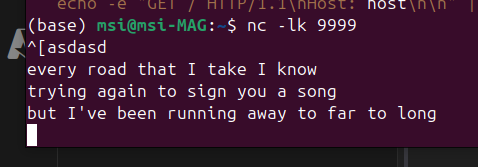

## Rate Data source
is for testing only, it generates data for you

In [4]:
rateSourceDF = spark.readStream.format("rate").option("rowsPerSecond","10").load()

In [5]:
rateQuery = rateSourceDF.writeStream\
.outputMode("update")\
.format("console")\
.option("truncate", "false")\
.start()

24/05/27 20:56:54 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-0455e5b7-1130-435c-ae84-ef6e7e6e23c4. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/27 20:56:54 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+
|timestamp|value|
+---------+-----+
+---------+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|2024-05-27 20:56:54.489|0    |
|2024-05-27 20:56:54.589|1    |
|2024-05-27 20:56:54.689|2    |
|2024-05-27 20:56:54.789|3    |
|2024-05-27 20:56:54.889|4    |
|2024-05-27 20:56:54.989|5    |
|2024-05-27 20:56:55.089|6    |
|2024-05-27 20:56:55.189|7    |
|2024-05-27 20:56:55.289|8    |
|2024-05-27 20:56:55.389|9    |
+-----------------------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+-----------------------+-----+
|timestamp              |value|
+-----------------------+-----+
|2024-05-27 20:56:55.489|10   |
|2024-05-27 20:56:55.589|11   |
|2024-05-27 20:56:55.689|12

In [6]:
rateQuery.stop() #terminate the influx of data

> One interesting thing to note is the number in the value column is guaranteed to be
consecutive across all the partitions. 

In [11]:
# with 3 partitions
rateSourceDF2 = spark.readStream.format("rate")\
.option("rowsPerSecond","4")\
.option("numPartitions",3).load()

-------------------------------------------
Batch: 17
-------------------------------------------
+-----------------------+-----+------------+
|timestamp              |value|partition_id|
+-----------------------+-----+------------+
|2024-05-27 21:01:06.489|16   |0           |
+-----------------------+-----+------------+

-------------------------------------------
Batch: 18
-------------------------------------------
+-----------------------+-----+------------+
|timestamp              |value|partition_id|
+-----------------------+-----+------------+
|2024-05-27 21:01:07.489|17   |0           |
+-----------------------+-----+------------+

-------------------------------------------
Batch: 19
-------------------------------------------
+-----------------------+-----+------------+
|timestamp              |value|partition_id|
+-----------------------+-----+------------+
|2024-05-27 21:01:08.489|18   |0           |
+-----------------------+-----+------------+

----------------------------

In [9]:
# add partition id column to examine
rateWithPartitionDF = rateSourceDF2.withColumn("partition_id", F.spark_partition_id())

In [12]:
rateWithPartitionQuery = rateWithPartitionDF.writeStream\
.outputMode("update")\
.format("console")\
.option("truncate", "false")\
.start()

24/05/27 21:01:19 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-4a6bfa8e-feda-4880-babf-4edf0ab228a3. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
24/05/27 21:01:19 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+---------+-----+------------+
|timestamp|value|partition_id|
+---------+-----+------------+
+---------+-----+------------+

-------------------------------------------
Batch: 29
-------------------------------------------
+-----------------------+-----+------------+
|timestamp              |value|partition_id|
+-----------------------+-----+------------+
|2024-05-27 21:01:18.489|28   |0           |
+-----------------------+-----+------------+

-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+------------+
|timestamp              |value|partition_id|
+-----------------------+-----+------------+
|2024-05-27 21:01:19.464|0    |0           |
+-----------------------+-----+------------+

-------------------------------------------
Batch: 30
-------------------------------------------
+-----------------------+-----+--